In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml
import geopandas as gpd
import shapely.geometry
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import cmocean.cm as cmo

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
# import dask

# import personal modules
# Path to modules
sys.path.append('../../modules')
# Import my modules
from utils import roundPartial, select_months_ds
from plotter import draw_basemap, plot_terrain, plot_arscale_cbar
from colorline import colorline

# dask.config.set(**{'array.slicing.split_large_chunks': True})

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/' 
path_to_out  = '../../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../../figs/'      # figures

In [3]:
# import configuration file for case study choice
yaml_doc = '../../data/domains.yml'
config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)

In [4]:
start_mon = 1
end_mon = 12

## load PRISM watershed precip dataset
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO_sp.nc'
PRISM = xr.open_dataset(fname)
## get just Nov - April
PRISM = select_months_ds(PRISM, start_mon, end_mon, 'date')

HUC8_lst = PRISM.HUC8.values ## get list of HUC8 IDs

## a quick function that assigns each watershed a basin value 
## based on the first 2 numbers of the HUC8 identifier

basin_lst = []
for i, HUC8_ID in enumerate(HUC8_lst):
    HUC2 = HUC8_ID[:2]
    if HUC2 == '14':
        basin = 'Colorado'
    elif HUC2 == '13':
        basin = 'Rio Grande'
    elif HUC2 == '11':
        basin = 'Arkansas'
    elif HUC2 == '10':
        basin = 'South Platte'
   
    basin_lst.append(basin)
    
ds_lst = []
for i, HUC8_ID in enumerate(HUC8_lst):
    fname = path_to_data +'preprocessed/ERA5_trajectories/combined_extreme_AR/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
    ds = xr.open_dataset(fname)
    ds_lst.append(ds)
    
## concat ds_lst along HUC8 index
ds = xr.concat(ds_lst, pd.Index(HUC8_lst, name="HUC8"))
## add the basin name as a coord
ds = ds.assign_coords({'basin': ("HUC8", basin_lst)})
ds = select_months_ds(ds, start_mon, end_mon, 'start_date')
ds

<xarray.Dataset>
Dimensions:             (index: 72, start_date: 1641, HUC8: 92)
Coordinates:
  * index               (index) int64 0 1 2 3 4 5 6 7 ... 65 66 67 68 69 70 71
  * start_date          (start_date) datetime64[ns] 2000-01-11 ... 2023-12-26
    time                (HUC8, start_date, index) datetime64[ns] NaT NaT ... NaT
    lon                 (HUC8, start_date, index) float64 nan nan ... nan nan
    lat                 (HUC8, start_date, index) float64 nan nan ... nan nan
  * HUC8                (HUC8) object '14080107' '14080105' ... '10250013'
    basin               (HUC8) <U12 'Colorado' 'Colorado' ... 'South Platte'
Data variables: (12/20)
    level               (HUC8, start_date, index) float64 nan nan ... nan nan
    q                   (HUC8, start_date, index) float64 nan nan ... nan nan
    u                   (HUC8, start_date, index) float64 nan nan ... nan nan
    v                   (HUC8, start_date, index) float64 nan nan ... nan nan
    w                   (HUC8, start_date, index) float64 nan nan ... nan nan
    IVT                 (HUC8, start_date, index) float64 nan nan ... nan nan
    ...                  ...
    ar_strict           (HUC8, start_date) float64 nan nan nan ... nan nan nan
    tARget_strict       (HUC8, start_date) float64 nan nan nan ... nan nan nan
    coastal_IVT_strict  (HUC8, start_date) float64 nan nan nan ... nan nan nan
    time_match          (HUC8, start_date) object nan nan nan ... nan nan nan
    lat_match           (HUC8, start_date) float64 nan nan nan ... nan nan nan
    lon_match           (HUC8, start_date) float64 nan nan nan ... nan nan nan

In [5]:
df_lst = []
for i, HUC8 in enumerate(HUC8_lst):

    tmp = ds.sel(HUC8=HUC8)
    tmp = tmp.where(tmp['ar_scale'] > 0, drop=True)
    time_match = tmp.time_match.values
    lat_match = tmp.lat_match.values
    lon_match = tmp.lon_match.values
    start_date = tmp.start_date.values
    
    d = {'landfall_time': time_match, 'lat': lat_match, 'lon': lon_match, 
         'HUC8': tmp.HUC8.values, 'start_date': start_date}
    df = pd.DataFrame(d)
    df_lst.append(df)

In [6]:
df = pd.concat(df_lst)
df

,landfall_time,lat,lon,HUC8,start_date
0,2003-02-25 02,29.75,-112.50,14080107,2003-02-26
1,2003-03-16 01,31.25,-113.50,14080107,2003-03-17
2,2003-09-09 08,31.25,-113.50,14080107,2003-09-10
3,2003-11-11 05,33.00,-117.25,14080107,2003-11-13
4,2004-04-02 01,24.00,-107.00,14080107,2004-04-04
...,...,...,...,...,...
11,2019-07-18 07,26.50,-97.50,10250013,2019-07-21
12,2019-08-09 21,27.00,-97.50,10250013,2019-08-12
13,2019-08-21 02,27.75,-97.25,10250013,2019-08-24
14,2021-05-15 22,29.25,-95.00,10250013,2021-05-18


In [7]:
## halfway time
def halfway_time(row):

    time1 = pd.to_datetime(row['start_date'])
    time2 = pd.to_datetime(row['landfall_time'])

    return time1 + (time2 - time1) / 2


In [8]:
# Apply the user-defined function to every row
df['halfway_time'] = df.apply(halfway_time, axis=1)
df

,landfall_time,lat,lon,HUC8,start_date,halfway_time
0,2003-02-25 02,29.75,-112.50,14080107,2003-02-26,2003-02-25 13:00:00
1,2003-03-16 01,31.25,-113.50,14080107,2003-03-17,2003-03-16 12:30:00
2,2003-09-09 08,31.25,-113.50,14080107,2003-09-10,2003-09-09 16:00:00
3,2003-11-11 05,33.00,-117.25,14080107,2003-11-13,2003-11-12 02:30:00
4,2004-04-02 01,24.00,-107.00,14080107,2004-04-04,2004-04-03 00:30:00
...,...,...,...,...,...,...
11,2019-07-18 07,26.50,-97.50,10250013,2019-07-21,2019-07-19 15:30:00
12,2019-08-09 21,27.00,-97.50,10250013,2019-08-12,2019-08-10 22:30:00
13,2019-08-21 02,27.75,-97.25,10250013,2019-08-24,2019-08-22 13:00:00
14,2021-05-15 22,29.25,-95.00,10250013,2021-05-18,2021-05-16 23:00:00


In [9]:
## break into subregions

In [10]:
df2 = df.pivot_table(index = ['lat', 'lon'], aggfunc ='size')
df2
df2 = df2.reset_index()
colname = df2.columns[-1]

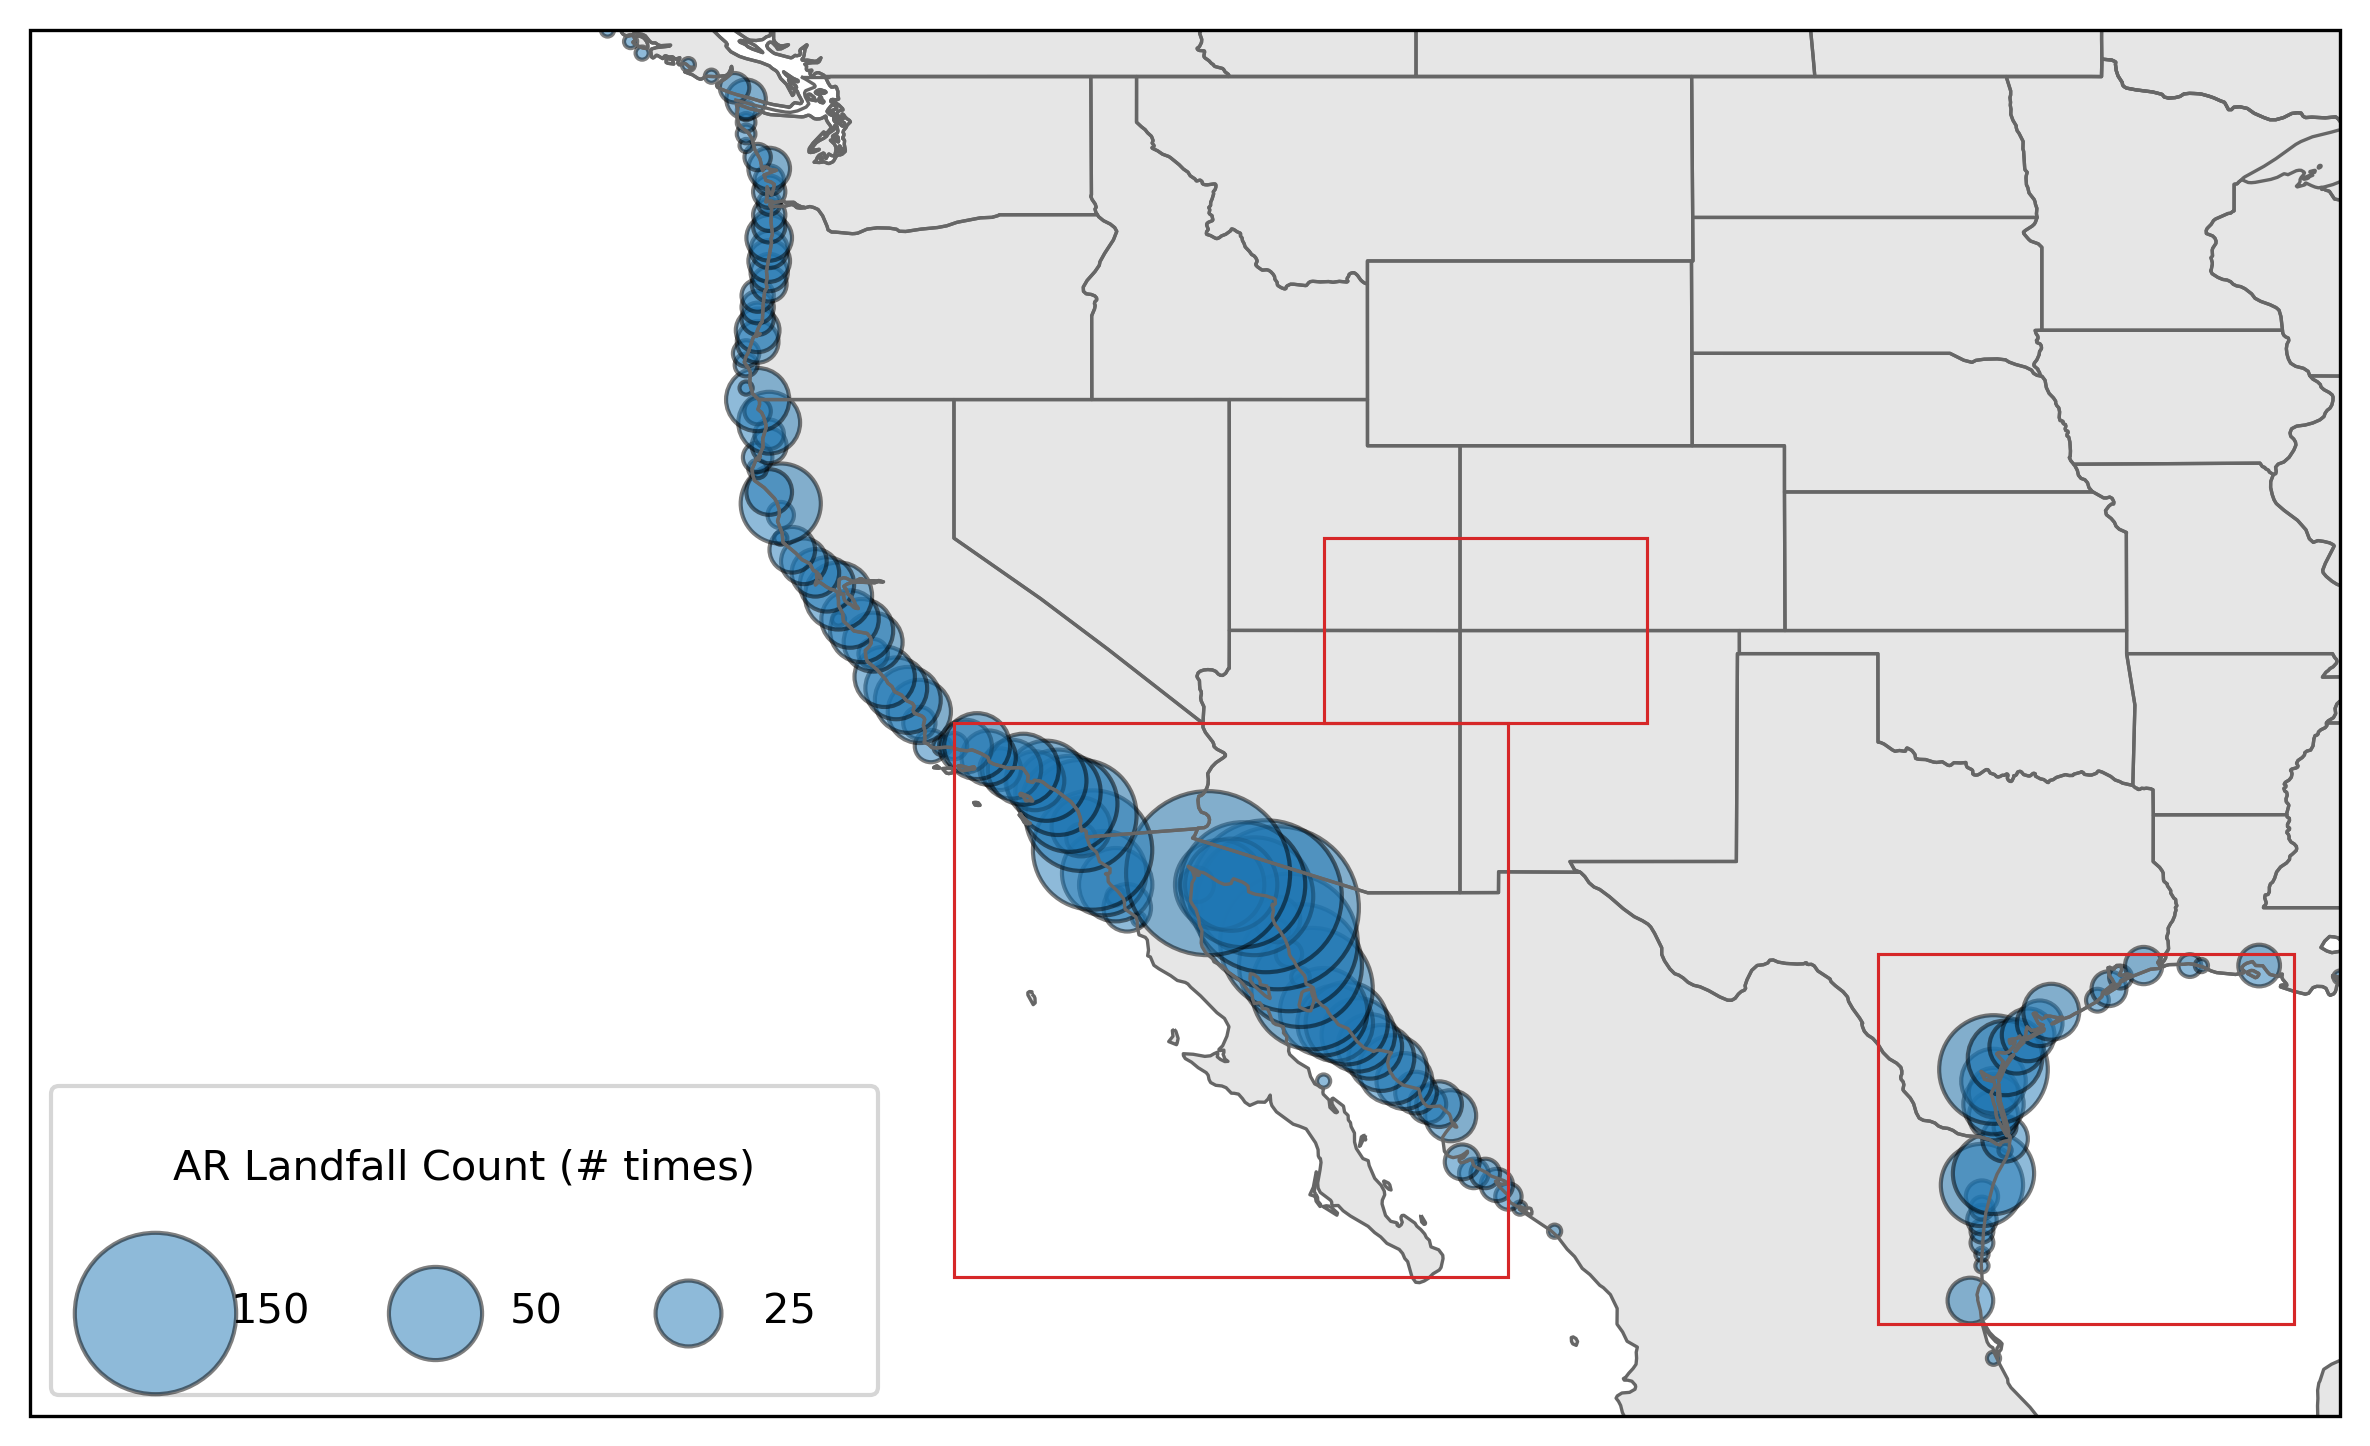

In [11]:
fname = path_to_figs + 'ar-landfall_freq'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((12.,6.))
fig.dpi = 300

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
ext = [-140., -90., 20, 50]
xticks = np.arange(ext[0],ext[1]+5,5)
yticks = np.arange(ext[2],ext[3]+5,5)
    
ax = plt.axes(projection=mapcrs)
ax.set_extent(ext, crs=datacrs)

# Add map features (continents and country borders)
ax.add_feature(cfeature.LAND, facecolor='0.9')      
ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.8)
ax.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.8)
ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

## Add ERA-Interim Gridlines and Labels
gl = ax.gridlines(crs=datacrs, draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(yticks)
gl.ylocator = mticker.FixedLocator(xticks)
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}

# Bubbles
x = df2.lon.values
y = df2.lat.values
z = df2[colname].values
scl = 10
sc = ax.scatter(x, y, s=z*scl, c='tab:blue', marker='o', alpha=0.5, transform=mapcrs, edgecolors='k')
# new = ax.scatter(lons_add, lats_add, s=250, c='tab:red', marker='o', alpha=0.5, transform=mapcrs, edgecolors='k')

# legend
msizes = [150*scl, 50*scl, 25*scl]
markers = []
for size in msizes:
    markers.append(plt.scatter([],[], s=size, c='tab:blue', edgecolors='k', label=(int(size/scl)), alpha=0.5))

ax.legend(handles=markers, loc='lower left', labelspacing=2.5, borderpad=1.5, title='AR Landfall Count (# times)', ncol=3)

## add extent of bbox
region_lst = ['baja', 'san_juan', 'gulf_of_mexico']
for i, region in enumerate(region_lst):
    ext3 = config[region]['ext']
    ax.add_patch(mpatches.Rectangle(xy=[ext3[0], ext3[2]], width=ext3[1]-ext3[0], height=ext3[3]-ext3[2],
                                        fill=False,
                                        edgecolor='tab:red',
                                        linewidth=0.75,
                                        transform=datacrs,
                                        zorder=199))


# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
plt.show()